In [78]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [98]:
df = pd.read_csv("logs.csv")

In [99]:
wr = sum(df['win']) / len(df) * 100
profit = df['profit'].sum()
print(f"Win Rate: {wr:.2f}%")
print(f"Profit: {profit:.2f}$")

Win Rate: 46.09%
Profit: 16.38$


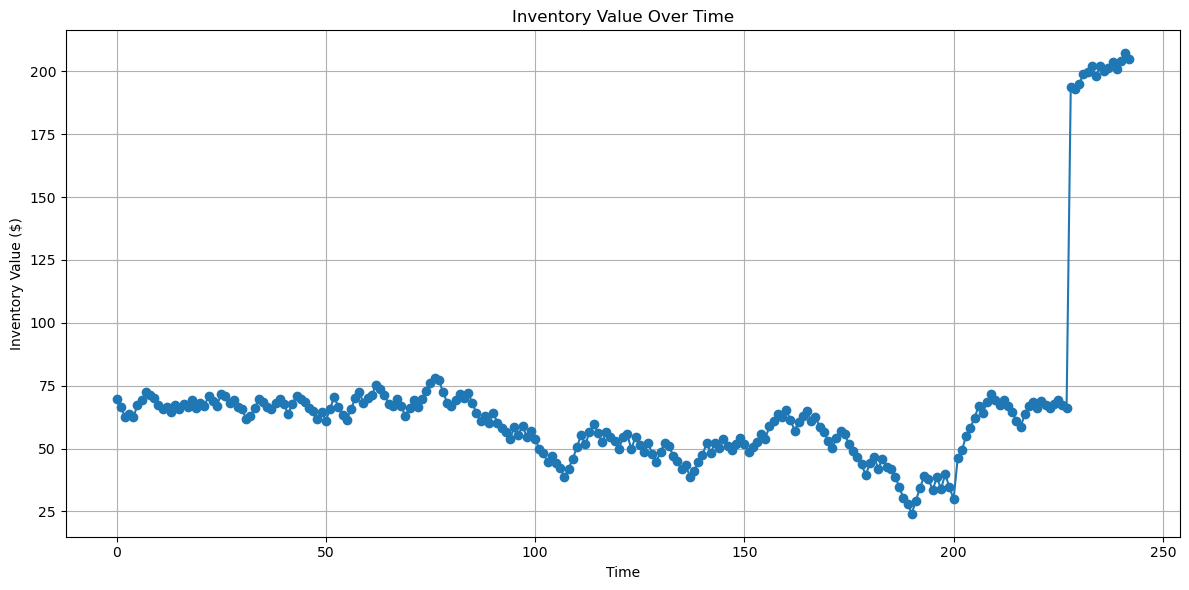

In [100]:
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(len(df["inventory_value"]))], df["inventory_value"], marker='o', linestyle='-')
plt.title("Inventory Value Over Time")
plt.xlabel("Time")
plt.ylabel("Inventory Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

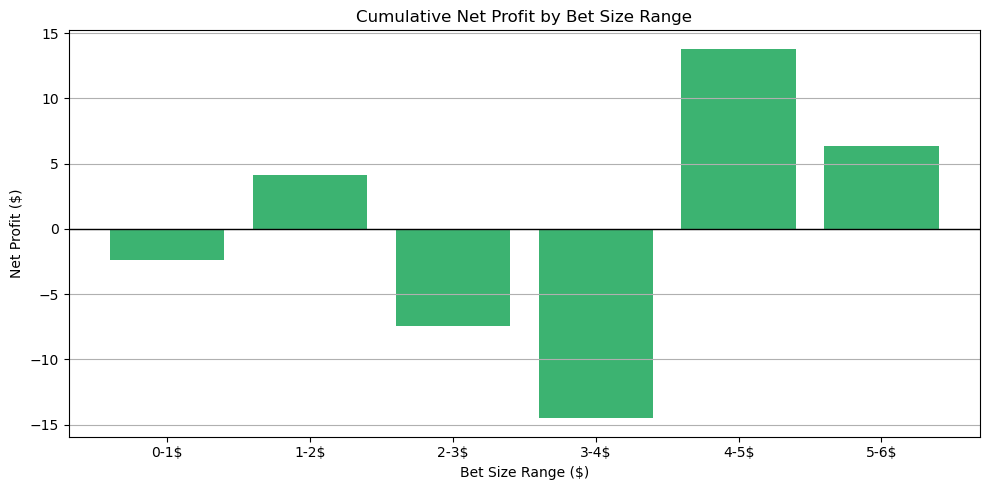

In [101]:
    # Compute profit per bet_bin
bins = np.arange(0, 7, 1)
labels = [f"{i}-{i+1}$" for i in bins[:-1]]

df["bet_bin"] = pd.cut(df["your_value"], bins=bins, labels=labels, right=False)
profit_by_bin = df.groupby("bet_bin")["profit"].sum()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(profit_by_bin.index, profit_by_bin.values, color="mediumseagreen")
plt.axhline(0, color='black', linewidth=1)
plt.title("Cumulative Net Profit by Bet Size Range")
plt.xlabel("Bet Size Range ($)")
plt.ylabel("Net Profit ($)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


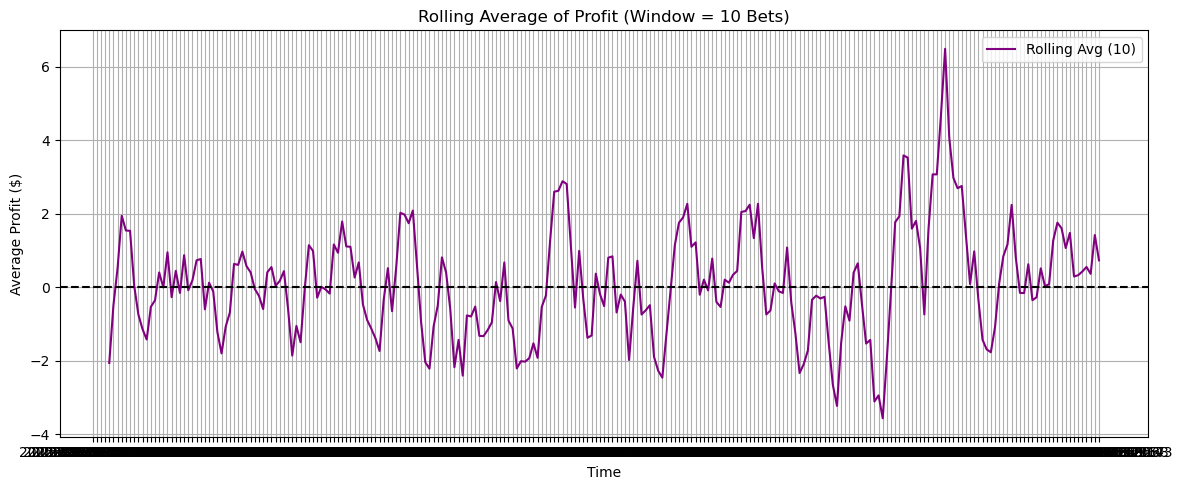

In [103]:
df["rolling_profit"] = df["profit"].rolling(window=5).mean()

plt.figure(figsize=(12, 5))
plt.plot(df["timestamp"], df["rolling_profit"], label="Rolling Avg (10)", color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title("Rolling Average of Profit (Window = 10 Bets)")
plt.xlabel("Time")
plt.ylabel("Average Profit ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [85]:
df['inventory_value'][:229] += 129.

In [104]:
df

,timestamp,your_value,opponent_value,win,profit,inventory_value,bet_bin,rolling_profit
0,2025-03-22 20:34:49,2.95,3.27,0,-2.95,69.71,2-3$,NaN
1,2025-03-22 20:36:17,3.08,3.42,0,-3.08,66.63,3-4$,NaN
2,2025-03-22 20:37:28,4.00,4.44,0,-4.00,62.63,4-5$,NaN
3,2025-03-22 20:39:16,0.98,1.08,1,1.08,63.71,0-1$,NaN
4,2025-03-22 20:40:32,1.32,1.41,0,-1.32,62.39,1-2$,-2.054
...,...,...,...,...,...,...,...,...
238,2025-03-24 00:14:16,2.34,2.59,1,2.59,203.88,2-3$,0.434
239,2025-03-24 00:15:26,3.01,3.34,0,-3.01,200.87,3-4$,0.558
240,2025-03-24 00:18:17,2.80,3.10,1,3.10,203.97,2-3$,0.370
241,2025-03-24 00:19:38,2.90,3.22,1,3.22,207.19,2-3$,1.426
